In [7]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Point cloud name
DATASET = 'paris_lille'
CLOUD = 'Lille_0'

# Input folder and timestamp to search for. Timestamp can be "latest" or a specific timestmap
FOLDER = os.path.join("out", CLOUD)
TIMESTAMP = 'latest'

# Output folder for the plots
PLOT_FOLDER = os.path.join("out", "plots", DATASET, CLOUD)
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Function to get the file based on the specified timestamp in the filename
def get_file_by_date(folder, date_str):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {folder}")
    
    if TIMESTAMP == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        latest_file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),  # Join list and then replace
            "%Y-%m-%d-%H:%M:%S"  # Correct datetime format
        ))
        print(f"Loading latest file: {latest_file}")
        return latest_file
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            timestamp_str = filename.split('-')[1:]  # Split to get timestamp part
            timestamp_str = '-'.join(timestamp_str).replace('.csv', '')  # Rebuild timestamp string
            
            if date_str == timestamp_str:
                print(f"Loading file: {file}")
                return file
        raise FileNotFoundError(f"File with date '{date_str}' not found in folder: {folder}")

In [8]:
# Read the file and put into pandas dataframe
data = get_file_by_date(FOLDER, TIMESTAMP)
df = pd.read_csv(data)

# Convert times to milliseconds
df['mean'] = df['mean'] * 1000
df['stdev'] = df['stdev'] * 1000

# Set the style
plt.style.use('default')
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.2)

# Define a consistent color palette for 'octree' categories
octree_types = df['octree'].unique()
palette = sns.color_palette("Set2", len(octree_types))
color_dict = dict(zip(octree_types, palette))

# Create a function for adding execution details to plot titles
def get_execution_details(data):
    search_size = data['num_searches'].iloc[0]
    repeats = data['repeats'].iloc[0]
    return f'\n\nSearch Size: {search_size:,} points, Repeats: {repeats}\n\nPoint cloud {CLOUD} in dataset {DATASET}'

Loading latest file: out/Lille_0/Lille_0-2024-12-19-13:25:38.csv


In [9]:
df.dtypes

date             object
octree           object
point_type       object
encoder          object
npoints           int64
operation        object
kernel           object
radius          float64
num_searches      int64
repeats           int64
accumulated     float64
mean            float64
median          float64
stdev           float64
used_warmup       int64
dtype: object

/home/pablo.diaz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


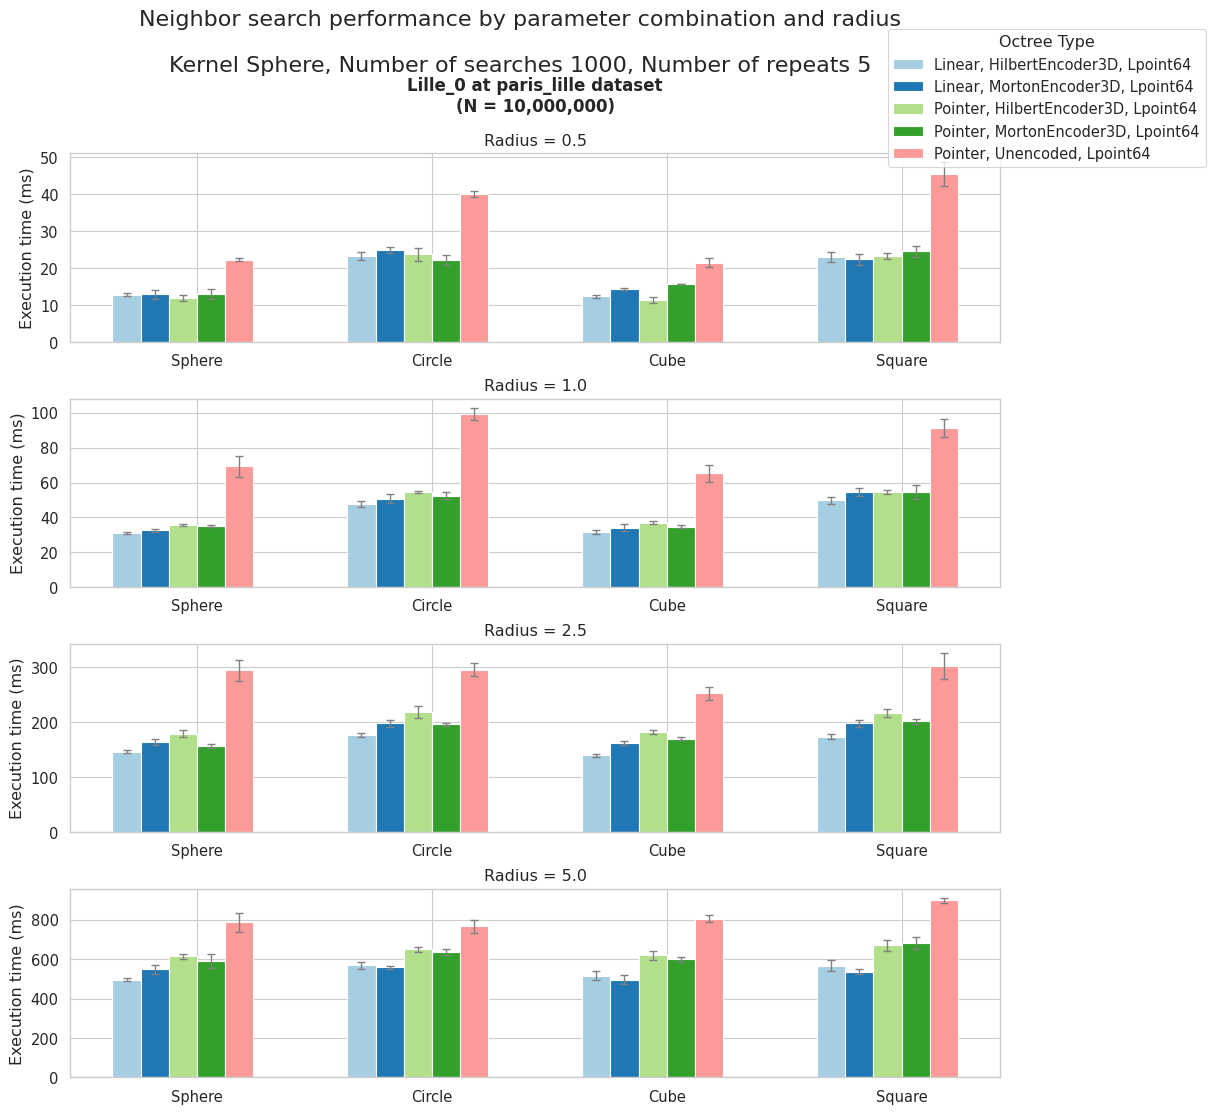

In [10]:
def create_performance_plot_matrix(df, operation, operation_name):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
   
    # Get unique parameter combinations
    parameter_combinations = df[['octree', 'encoder', 'point_type']].drop_duplicates().sort_values(
        by=['octree', 'encoder', 'point_type'], ascending=[True, True, True]
    )
    palette = sns.color_palette("Paired", len(parameter_combinations))
    color_dict = {
        (row['octree'], row['encoder'], row['point_type']): color
        for row, color in zip(parameter_combinations.to_dict(orient='records'), palette)
    }
   
    # Filter for the specified operation
    operation_df = df[df['operation'] == operation]
   
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)), 
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
   
    bar_width = 0.15  # Width of individual bars
    group_width = bar_width * len(parameter_combinations)  # Total width of kernel group
    group_gap = 0.5  # Space between kernel groups
   
    # Prepare legend handles and labels to avoid duplicates
    legend_handles, legend_labels = [], []
    nsearches = df['num_searches'].iloc[0]  # Number of searches
    nrepeats = df['repeats'].iloc[0]  # Number of repeats
    npoints = df['npoints'].iloc[0]  # Number of points
   
    # Create plots for each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
       
        # Iterate through kernels
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
           
            for j, (_, combination) in enumerate(parameter_combinations.iterrows()):
                octree, encoder, point_type = combination['octree'], combination['encoder'], combination['point_type']
                combo_data = kernel_data[
                    (kernel_data['octree'] == octree) & 
                    (kernel_data['encoder'] == encoder) & 
                    (kernel_data['point_type'] == point_type)
                ]
               
                if not combo_data.empty:
                    # Extract means and standard deviations
                    means = combo_data['mean'].values
                    stdevs = combo_data['stdev'].values
                   
                    # Position bars within kernel group
                    x_pos = i * (group_width + group_gap) + j * bar_width
                   
                    # Plot bars and error bars
                    bar = ax.bar(x_pos, means[0], bar_width, 
                                 color=color_dict[(octree, encoder, point_type)])
                    ax.errorbar(x_pos, means[0], stdevs[0], 
                                color='gray', capsize=3, capthick=1,
                                fmt='none', elinewidth=1)
                    
                    # Collect unique legend handles
                    if radius_idx == 0 and (octree, encoder, point_type) not in legend_labels:
                        legend_handles.append(bar)
                        legend_labels.append((octree, encoder, point_type))
       
        # Set x-ticks to center of each kernel group
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernels)
        
        ax.set_title(f'Radius = {radius}')
        ax.set_ylabel('Execution time (ms)')
        if radius_idx == 0:
            ax.text(0.5, 1.2, f"{CLOUD} at {DATASET} dataset\n(N = {npoints:,})", transform=ax.transAxes, 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
   
    # Add legend outside the plot area
    fig.legend(legend_handles, 
               [f"{octree}, {encoder}, {point_type}" for octree, encoder, point_type in legend_labels], 
               title='Octree Type', 
               loc='upper left', bbox_to_anchor=(0.8, 0.99))
    
    # Overall title with adjusted y parameter
    fig.suptitle(operation_name + f' performance by parameter combination and radius\n\nKernel {kernels[0]}, Number of searches {nsearches}, Number of repeats {nrepeats}', 
                 y=1, fontsize=16)
   
    plt.tight_layout()
    return fig

# Usage
fig = create_performance_plot_matrix(df, 'neighSearch', 'Neighbor search')
plt.savefig(os.path.join(PLOT_FOLDER, 'neighbor_search_performance.png'), dpi=300, bbox_inches='tight')

/home/pablo.diaz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


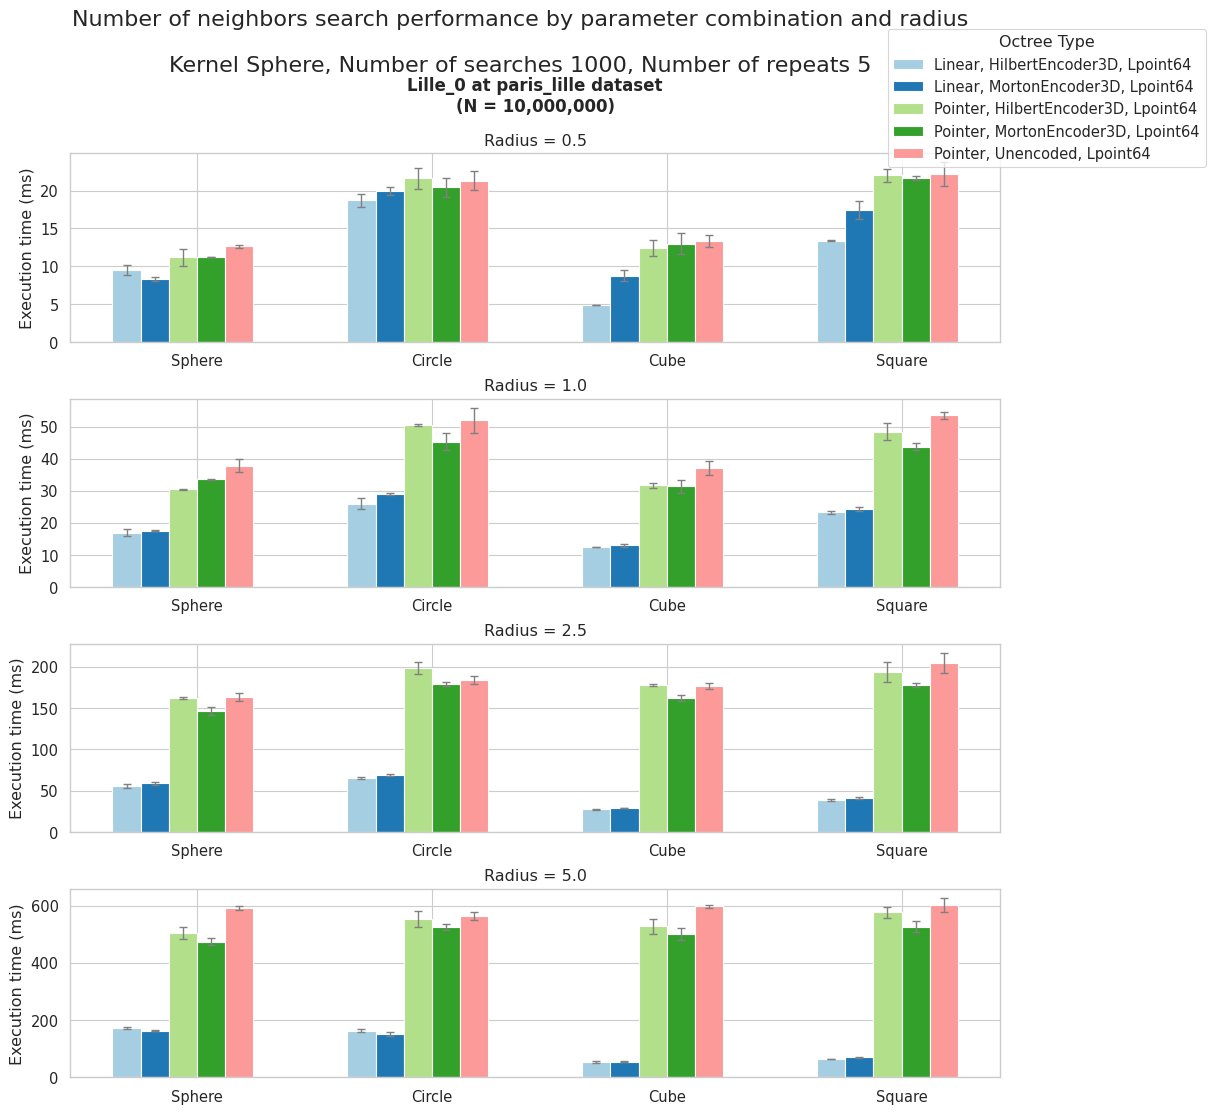

In [11]:
fig = create_performance_plot_matrix(df, 'numNeighSearch', 'Number of neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'num_neighbor_performance.png'), dpi=300, bbox_inches='tight')

In [12]:
# # 3. KNN and Ring Search Performance (with measured std dev)
# plt.figure(figsize=(10, 7))
# other_ops_df = df[df['operation'].isin(['KNN', 'ringNeighSearch'])]

# # Create error bar plot
# ax = plt.gca()
# bar_width = 0.35
# x_positions = []
# for i, operation in enumerate(other_ops_df['operation'].unique()):
#     op_data = other_ops_df[other_ops_df['operation'] == operation]
#     x_pos = [i - bar_width/2, i + bar_width/2]
#     x_positions.extend(x_pos)
    
#     for j, (idx, row) in enumerate(op_data.iterrows()):
#         x = x_pos[j]
#         plt.bar(x, row['mean'], bar_width, 
#                 color=color_dict[row['octree']], 
#                 label=row['octree'] if i == 0 else "")
#         plt.errorbar(x, row['mean'], row['stdev'], 
#                     color='black', capsize=3, capthick=1, 
#                     fmt='none', elinewidth=1)
#         # Add value labels
#         # plt.text(x, row['mean'], f'{row["mean"]:.2f}', 
#         #         ha='center', va='bottom')

# plt.xticks(range(len(other_ops_df['operation'].unique())), 
#            other_ops_df['operation'].unique())
# plt.title('KNN and Ring Search Performance' + 
#           get_execution_details(other_ops_df), 
#           pad=20)
# plt.xlabel('Operation Type')
# plt.ylabel('Mean Runtime (milliseconds)')
# plt.legend(title='Octree Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.savefig(os.path.join(PLOT_FOLDER, 'knn_ring_search_performance.png'), dpi=300, bbox_inches='tight')